<a href="https://colab.research.google.com/github/areias/slm-finetunig/blob/main/fine_tune_mistral2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER Tagging


https://discuss.huggingface.co/t/reduced-inference-f1-score-with-qlora-finetuned-model/53492


https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/README.rst


add f1 to validation run
named entity task

https://www.clips.uantwerpen.be/conll2003/ner/


found a paper that shows gpt3.5 had zero shot f1 of 0.53 for NER using person, organization, location and misc https://arxiv.org/pdf/2302.06476.pdf

https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

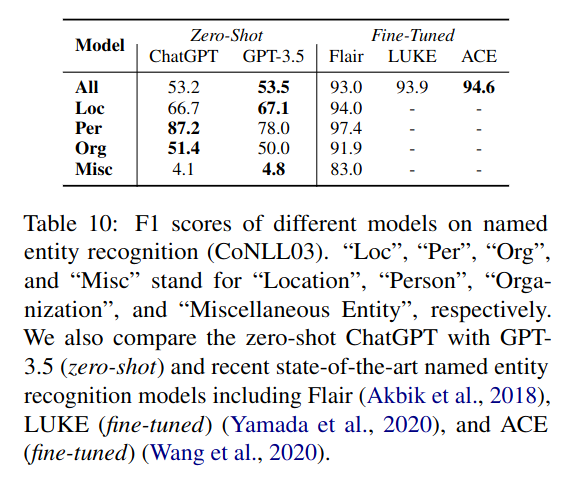





## Load and preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [ ]:
pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset['train'][0]['tokens']

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [ ]:
ner_tags= {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [ ]:
# Swap keys and values using dictionary comprehension
swapped_dict = {v: k for k, v in ner_tags.items()}

# Print the swapped dictionary
print(swapped_dict)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


In [ ]:
[swapped_dict[x] for x in dataset['train'][0]['ner_tags']]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [ ]:
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
def label_tokens(entry):
    entry['ner_labels'] = [swapped_dict[x] for x in entry['ner_tags']]
    return entry


In [ ]:
dataset['train'] = dataset["train"].map(label_tokens)
dataset['test'] = dataset["test"].map(label_tokens)
dataset['validation'] = dataset["validation"].map(label_tokens)


In [ ]:
def tokens_to_sentence(entry):
    entry['sentence'] = ' '.join(entry['tokens'])
    return entry

dataset['train'] = dataset["train"].map(tokens_to_sentence)
dataset['test'] = dataset["test"].map(tokens_to_sentence)
dataset['validation'] = dataset["validation"].map(tokens_to_sentence)


In [ ]:
def extract_entities(entry):
    entities = {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []}
    current_entity = {"type": None, "words": []}
    for word, label in zip(entry['sentence'].split(), entry['ner_labels']):
        if label.startswith('B-'):
            entity_type = label.split('-')[1]
            if current_entity["type"] == entity_type:
                entities[entity_type].append(' '.join(current_entity["words"]))
                current_entity["words"] = [word]
            else:
                if current_entity["type"] is not None:
                    entities[current_entity["type"]].append(' '.join(current_entity["words"]))
                current_entity = {"type": entity_type, "words": [word]}
        elif label.startswith('I-'):
            if current_entity["type"] is not None:
                current_entity["words"].append(word)
        else:
            if current_entity["type"] is not None:
                entities[current_entity["type"]].append(' '.join(current_entity["words"]))
            current_entity = {"type": None, "words": []}
    if current_entity["type"] is not None:
        entities[current_entity["type"]].append(' '.join(current_entity["words"]))

    entry['entities'] = entities
    return entry

# Extract entities
dataset['train'] = dataset["train"].map(extract_entities)
dataset['test'] = dataset["test"].map(extract_entities)
dataset['validation'] = dataset["validation"].map(extract_entities)



In [ ]:
dataset['train'][10]['sentence'], dataset['train'][10]['entities']

('Spanish Farm Minister Loyola de Palacio had earlier accused Fischler at an EU farm ministers \' meeting of causing unjustified alarm through " dangerous generalisation . "',
 {'LOC': [],
  'MISC': ['Spanish'],
  'ORG': ['EU'],
  'PER': ['Loyola de Palacio', 'Fischler']})

In [ ]:
def eval_formatting_func(entry):
    # tokenizer adds bos token
    text = (f"[INST] You are an NLP expert tasked with Named Entity Extraction. "
        f"Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: '{entry['sentence']}'\n"
        "Your answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} \n"
        "Take care, your answer is only valid if it follows the correct format! [/INST]")

    return text


In [ ]:
print(eval_formatting_func(dataset['train'][10]))

[INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: 'Spanish Farm Minister Loyola de Palacio had earlier accused Fischler at an EU farm ministers ' meeting of causing unjustified alarm through " dangerous generalisation . "'
Your answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} 
Take care, your answer is only valid if it follows the correct format! [/INST]


In [ ]:
eval_tokenizer.decode(eval_tokenizer(eval_formatting_func(dataset['train'][10]))['input_ids'])

'<s> [INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: \'Spanish Farm Minister Loyola de Palacio had earlier accused Fischler at an EU farm ministers \' meeting of causing unjustified alarm through " dangerous generalisation . "\'\nYour answer must be in the form of a dict {\'PER\':[\'person entity 1\', \'person entity 2\', \'...\'], \'ORG\': [], \'LOC\': [], \'MISC\': []} \nTake care, your answer is only valid if it follows the correct format! [/INST]'

In [ ]:
def formatting_func(entry):
    #tokenizer add bos token
    text = (f"[INST] You are an NLP expert tasked with Named Entity Extraction. "
        f"Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: '{entry['sentence']}'\n"
        "Your answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} \n"
        "Take care, your answer is only valid if it follows the correct format! [/INST]\n"
        f"{entry['entities']}</s>")

    return text


In [ ]:
print(formatting_func(dataset['train'][10]))

[INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: 'Spanish Farm Minister Loyola de Palacio had earlier accused Fischler at an EU farm ministers ' meeting of causing unjustified alarm through " dangerous generalisation . "'
Your answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} 
Take care, your answer is only valid if it follows the correct format! [/INST]
{'LOC': [], 'MISC': ['Spanish'], 'ORG': ['EU'], 'PER': ['Loyola de Palacio', 'Fischler']}</s>


In [ ]:
import random

# Get the length of the training split
train_length = len(dataset['train'])
test_length  = len(dataset['test'])

# Sample 100 random indices
random.seed(42)
train_random_indices = random.sample(range(train_length), 1000)

random.seed(42)
test_random_indices = random.sample(range(test_length), 100)

# Retrieve the sampled entries
#train_sample = [dataset['train'][idx] for idx in train_random_indices]
test_sample = [dataset['test'][idx] for idx in test_random_indices]

# Take a sample of the training split
sample_size = 1000
train_sample = dataset["train"].shuffle(seed=42).select(range(sample_size))

val_sample = dataset["validation"].shuffle(seed=42).select(range(200))


In [ ]:
val_sample

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'ner_labels', 'sentence', 'entities'],
    num_rows: 200
})

In [ ]:
from collections import Counter

def get_count(entries):
    # Initialize counters for each entity type
    per_counter = Counter()
    org_counter = Counter()
    loc_counter = Counter()
    misc_counter = Counter()

    # Count the occurrences of each type of entity
    for item in entries:
        per_counter.update(item['entities']['PER'])
        org_counter.update(item['entities']['ORG'])
        loc_counter.update(item['entities']['LOC'])
        misc_counter.update(item['entities']['MISC'])

    # Print the counts for each type of entity
    print("Total PER entities:", sum(per_counter.values()))
    print("Total ORG entities:", sum(org_counter.values()))
    print("Total LOC entities:", sum(loc_counter.values()))
    print("Total MISC entities:", sum(misc_counter.values()))


In [ ]:
get_count(train_sample)

Total PER entities: 445
Total ORG entities: 437
Total LOC entities: 516
Total MISC entities: 258


In [ ]:
get_count(test_sample)

Total PER entities: 41
Total ORG entities: 43
Total LOC entities: 45
Total MISC entities: 12


In [ ]:
get_count(val_sample)

Total PER entities: 130
Total ORG entities: 67
Total LOC entities: 120
Total MISC entities: 48


In [ ]:
import json

# Save the list of items to a JSON file
with open("drive/MyDrive/mistral-finetune/data/train_sample.json", 'w') as f:
    json.dump(train_sample, f, indent=4)

In [ ]:
with open("drive/MyDrive/mistral-finetune/data/test_sample.json", 'w') as f:
    json.dump(test_sample, f, indent=4)


NameError: name 'json' is not defined

## Evaluate model out of the box

In [ ]:
!ls drive/MyDrive/ner-finetuning/

checkpoint-450	checkpoint-450-20240301T110956Z-001.zip  test_sample_basepreds.json


In [ ]:
import json
with open("drive/MyDrive/ner-finetuning/test_sample_basepreds.json", 'r') as f:
    test_sample=json.load(f)

In [ ]:
"""with open("drive/MyDrive/mistral-finetune/data/test_sample.json", 'r') as f:
    test_sample=json.load(f)"""

In [ ]:
! pip install -q peft
! pip install -q git+https://github.com/huggingface/accelerate.git
! pip install -q bitsandbytes
! pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 2.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
idx=45

eval_prompt = eval_formatting_func(test_sample[idx])
print(eval_prompt)

<s>[INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: 'A police spokesman said two youths believed to be supporters of President Nelson Mandela 's African National Congress ( ANC ) had been killed when unknown gunmen opened fire at the rural settlement of Izingolweni on KwaZulu-Natal province 's south coast on Thursday night .'
Your answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} 
Take care, your answer is only valid if it follows the correct format! [/INST]


In [ ]:
ground_truth = test_sample[idx]['entities']
ground_truth

{'PER': ['Nelson Mandela'],
 'ORG': ['African National Congress', 'ANC'],
 'LOC': ['Izingolweni', 'KwaZulu-Natal'],
 'MISC': []}

In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response  = eval_tokenizer.decode(model.generate(**model_input,
                    max_new_tokens=256, repetition_penalty=1.15,
                    pad_token_id=eval_tokenizer.eos_token_id)[0], skip_special_tokens=True)
    response = response.replace(eval_prompt, "")
    print(response)

 {'PER': ['President Nelson Mandela', 'two youths'], 'ORG': ['African National Congress ( ANC )'], 'LOC': ['Izingolweni', 'KwaZulu- Natal province''s south coast'], 'MISC': []}


In [ ]:
import re
def parse_response(sentence):
    # Find the text between curly braces
    match = re.search(r'\{[^{}]+\}', response)
    # If a match is found, evaluate it as a dictionary using eval

    if match:
        entities_str = match.group(0)
        try:
            entities_dict = eval(entities_str)
            return entities_dict
        except:
            return {'PER':[], 'ORG':[], 'LOC':[], 'MISC':[]}
    else:
        # If no match is found, return an empty dictionary
        return {'PER':[], 'ORG':[], 'LOC':[], 'MISC':[]}

In [ ]:
response_dict = parse_response(response)
response_dict

{'PER': ['President Nelson Mandela', 'two youths'],
 'ORG': ['African National Congress ( ANC )'],
 'LOC': ['Izingolweni', 'KwaZulu- Natal provinces south coast'],
 'MISC': []}

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm


for idx in tqdm(range(len(test_sample))):

    eval_prompt = formatting_func(test_sample[idx])

    ground_truth = test_sample[idx]['entities']

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(model.generate(**model_input,
                        max_new_tokens=256, repetition_penalty=1.15,
                        pad_token_id=eval_tokenizer.eos_token_id)[0], skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    response_dict = parse_response(response)

    metrics = calculate_metrics(ground_truth, response_dict)

    test_sample[idx].update({'base_model': {'response': response,
                                 'response_dict': response_dict,
                                 'metrics': metrics}})

100%|██████████| 100/100 [14:18<00:00,  8.58s/it]


In [ ]:
with open("drive/MyDrive/mistral-finetune/data/test_sample_basepreds.json", 'w') as f:
    json.dump(test_sample, f, indent=4)

In [ ]:
import json
with open("drive/MyDrive/mistral-finetune/data/test_sample_basepreds.json", 'r') as f:
    test_sample = json.load(f)

In [ ]:
len(test_sample)

100

In [ ]:
test_sample[1] # this is wrong


{'id': '456',
 'tokens': ['WESTERN', 'CONFERENCE'],
 'pos_tags': [22, 22],
 'chunk_tags': [11, 12],
 'ner_tags': [0, 0],
 'labels': ['O', 'O'],
 'sentence': 'WESTERN CONFERENCE',
 'entities': {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []},
 'base_model': {'response': " Based on the given sentence, there are no identifiable PER, ORG, LOC or MISC entities present. Therefore, the output will be: {'PER':[], 'ORG': ['WESTERN CONFERENCE'], 'LOC': [], 'MISC':[]} \nPlease note that WESTERN CONFERENCE is identified as an ORG entity.",
  'response_dict': {'PER': [],
   'ORG': ['WESTERN CONFERENCE'],
   'LOC': [],
   'MISC': []},
  'metrics': {'PER': [1.0, 1.0, 1.0],
   'ORG': [0.0, 0, 0],
   'LOC': [1.0, 1.0, 1.0],
   'MISC': [1.0, 1.0, 1.0]}}}

In [ ]:
test_sample[1]['base_model']['response_dict']

{'PER': [], 'ORG': ['WESTERN CONFERENCE'], 'LOC': [], 'MISC': []}

In [ ]:
test_sample[1]['entities']

{'PER': [], 'ORG': [], 'LOC': [], 'MISC': []}

In [ ]:
test_sample[1]['base_model']['metrics']

{'PER': [1.0, 1.0, 1.0],
 'ORG': [1.0, 1.0, 1.0],
 'LOC': [1.0, 1.0, 1.0],
 'MISC': [1.0, 1.0, 1.0],
 'Total': [0.0, 0, 0]}

In [ ]:
idx=5
test_sample[idx]['entities']['PER'],test_sample[idx]['base_model']['response_dict']['PER']

([], ['the 35-year-old woman'])

In [ ]:
test_sample[idx]['base_model']['metrics']

{'PER': [1.0, 1.0, 1.0],
 'ORG': [1.0, 1.0, 1.0],
 'LOC': [1.0, 1.0, 1.0],
 'MISC': [1.0, 1.0, 1.0],
 'Total': [0.0, 0, 0]}

In [ ]:
def precision(actual, predicted):
    actual_lower = [word.lower() for word in actual]
    predicted_lower = [word.lower() for word in predicted]

    if not actual_lower and not predicted_lower:
        return 1.0  # Both lists are empty, so precision is 1 (correct prediction)

    true_positives = sum(1 for p in predicted_lower if p in actual_lower)
    predicted_positives = len(predicted_lower)
    if predicted_positives == 0:
        return 0  # Handle case where there are no predicted positives to avoid division by zero
    return true_positives / predicted_positives

In [ ]:
def recall(actual, predicted):
    actual_lower = [word.lower() for word in actual]
    predicted_lower = [word.lower() for word in predicted]

    if not actual_lower and not predicted_lower:
        return 1.0  # Both lists are empty, so recall is 1 (correct prediction)

    true_positives = sum(1 for p in predicted_lower if p in actual_lower)
    actual_positives = len(actual_lower)
    if actual_positives == 0:
        return 0  # Handle case where there are no actual positives to avoid division by zero
    return true_positives / actual_positives


In [ ]:
def f1_score(actual, predicted):
    prec = precision(actual, predicted)
    rec = recall(actual, predicted)
    if prec + rec == 0:
        return 0  # Handle case where precision + recall is zero to avoid division by zero
    return 2 * (prec * rec) / (prec + rec)

https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

The Language-Independent Named Entity Recognition task introduced at CoNLL-2003 measures the performance of the systems in terms of precision, recall and f1-score, where:

“precision is the percentage of named entities found by the learning system that are correct. Recall is the percentage of named entities in the corpus found by the system. A named entity is correct only if it is an exact match of the corresponding entity in the data file.”



In [ ]:
# Test case 1: Both lists are empty (correct prediction)
actual1 = []
predicted1 = []
# Test case 2: Both lists contain the same words in the same order (perfect prediction)
actual2 = ["apple", "banana", "cherry"]
predicted2 = ["apple", "banana", "cherry"]
# Test case 3: Both lists contain the same words in different order (perfect prediction)
actual3 = ["apple", "banana", "cherry"]
predicted3 = ["banana", "apple", "cherry"]
# Test case 4: Both lists contain the same words in different case (perfect prediction due to case insensitivity)
actual4 = ["apple", "banana", "cherry"]
predicted4 = ["APPLE", "Banana", "CHERRY"]
# Test case 5: No predicted words match any actual words (zero precision)
actual5 = ["apple", "banana", "cherry"]
predicted5 = ["orange", "grape", "pear"]
# Test case 6: No actual words match any predicted words (zero recall)
actual6 = ["apple", "banana", "cherry"]
predicted6 = ["orange", "grape", "pear"]
# Test case 7: Both lists are large, contain various words, with some correct predictions (non-zero precision and recall)
actual7 = ["apple", "banana", "cherry"] * 1000
predicted7 = ["apple", "pear", "grape"] * 1000
# Test case 8: Both lists are large, contain various words, with no correct predictions (zero precision and recall)
actual8 = ["apple", "banana", "cherry"] * 1000
predicted8 = ["orange", "melon", "strawberry"] * 1000

# Calculate metrics for each test case
test_cases = [
    (actual1, predicted1),
    (actual2, predicted2),
    (actual3, predicted3),
    (actual4, predicted4),
    (actual5, predicted5),
    (actual6, predicted6),
    (actual7, predicted7),
    (actual8, predicted8)
]

for i, (actual, predicted) in enumerate(test_cases):
    prec = precision(actual, predicted)
    rec = recall(actual, predicted)
    f1 = f1_score(actual, predicted)
    print(f"Test case {i+1}:")
    print(f"Actual: {actual}")
    print(f"Predicted: {predicted}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1 Score: {f1}")
    print()


Test case 1:
Actual: []
Predicted: []
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test case 2:
Actual: ['apple', 'banana', 'cherry']
Predicted: ['apple', 'banana', 'cherry']
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test case 3:
Actual: ['apple', 'banana', 'cherry']
Predicted: ['banana', 'apple', 'cherry']
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test case 4:
Actual: ['apple', 'banana', 'cherry']
Predicted: ['APPLE', 'Banana', 'CHERRY']
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test case 5:
Actual: ['apple', 'banana', 'cherry']
Predicted: ['orange', 'grape', 'pear']
Precision: 0.0
Recall: 0.0
F1 Score: 0

Test case 6:
Actual: ['apple', 'banana', 'cherry']
Predicted: ['orange', 'grape', 'pear']
Precision: 0.0
Recall: 0.0
F1 Score: 0

Test case 7:
Actual: ['apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'apple', 'banana', 'cherry', 'app

In [ ]:
for idx, entry in enumerate(test_sample):
    for label in entry['entities'].keys():
        try:
            p = precision(entry['entities'][label], entry['base_model']['response_dict'][label])
            r = recall(entry['entities'][label], entry['base_model']['response_dict'][label])
            f = f1_score(entry['entities'][label], entry['base_model']['response_dict'][label])

            entry['base_model']['metrics'][label] = (p,r,f)
            print(label, entry['entities'][label], entry['base_model']['response_dict'][label], p, r, f)
        except: # answer dict doesnt have this label
            if entry['entities'][label]==[]: # if there is no entity for that label, then is correct
                entry['base_model']['metrics'][label] = (1,1,1)
            else:
                entry['base_model']['metrics'][label] = (0,0,0) # else it is wrong
            print(idx)
        try:
            entry['base_model']['metrics'].pop("Total")
        except:
            pass

PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] ['WESTERN CONFERENCE'] 0.0 0 0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER ['Wasim Akram', 'Harris'] ['Wasim Akram', 'Harris'] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['Mansfield'] [] 0 0.0 0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['New York Commodities'] ['New York Commodities Desk'] 0.0 0.0 0
LOC [] [] 1.0 1.0 1.0
MISC [] ['212-859-1640'] 0.0 0 0
PER [] ['the 35-year-old woman'] 0.0 0 0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['Bucharest Newsroom'] [] 0 0.0 0
LOC [] ['Bucharest Newsroom'] 0.0 0 0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['Wycombe'] [] 0 0.0 0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0

In [ ]:
test_sample[57]['entities'],test_sample[57]['base_model']['response_dict'], test_sample[57]['base_model']['metrics']

({'PER': [], 'ORG': ['Ljubljana'], 'LOC': ['Slovenia'], 'MISC': []},
 {'LOC': ['Ljubljana']},
 {'PER': (1, 1, 1), 'ORG': (0, 0, 0), 'LOC': (0.0, 0.0, 0), 'MISC': (1, 1, 1)})

In [50]:
def calculate_average_metrics(data):
    # Initialize variables to store sum of precision, recall, and f1_score for each entity type
    sum_precision = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    sum_recall = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    sum_f1_score = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    num_instances = len(data)

    # Iterate over the list of dictionaries
    for entry in data:
        metrics = entry['base_model']['metrics']
        for entity_type, (precision, recall, f1_score) in metrics.items():
            sum_precision[entity_type] += precision
            sum_recall[entity_type] += recall
            sum_f1_score[entity_type] += f1_score

    # Calculate average precision, recall, and f1_score for each entity type
    avg_precision = {entity_type: sum_precision[entity_type] / num_instances for entity_type in sum_precision}
    avg_recall = {entity_type: sum_recall[entity_type] / num_instances for entity_type in sum_recall}
    avg_f1_score = {entity_type: sum_f1_score[entity_type] / num_instances for entity_type in sum_f1_score}

    return avg_precision, avg_recall, avg_f1_score


In [ ]:
# Calculate average precision, recall, and f1_score
avg_precision, avg_recall, avg_f1_score = calculate_average_metrics(test_sample)

# Print the results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)


Average Precision: {'PER': 0.88, 'ORG': 0.67, 'LOC': 0.76, 'MISC': 0.77}
Average Recall: {'PER': 0.87, 'ORG': 0.665, 'LOC': 0.755, 'MISC': 0.77}
Average F1-score: {'PER': 0.8733333333333334, 'ORG': 0.6666666666666665, 'LOC': 0.755, 'MISC': 0.77}


In [ ]:
def calculate_average_for_each_position(data):
    # Initialize variables to store sum of values for each position
    sum_position1 = 0
    sum_position2 = 0
    sum_position3 = 0
    num_instances = len(data)

    # Iterate over the list of tuples
    for tpl in data:
        sum_position1 += tpl[0]
        sum_position2 += tpl[1]
        sum_position3 += tpl[2]

    # Calculate average for each position
    avg_position1 = sum_position1 / num_instances
    avg_position2 = sum_position2 / num_instances
    avg_position3 = sum_position3 / num_instances

    return round(avg_position1,2), round(avg_position2,2), round(avg_position3,2)



In [ ]:
#percision, recall, f1
calculate_average_for_each_position([x['base_model']['metrics']['PER'] for x in test_sample])

(0.88, 0.87, 0.87)

In [ ]:
calculate_average_for_each_position([x['base_model']['metrics']['ORG'] for x in test_sample])

(0.67, 0.67, 0.67)

In [ ]:
calculate_average_for_each_position([x['base_model']['metrics']['LOC'] for x in test_sample])

(0.76, 0.76, 0.76)

In [ ]:
calculate_average_for_each_position([x['base_model']['metrics']['MISC'] for x in test_sample])

(0.77, 0.77, 0.77)

## Fine-tuning with QLoRA

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                        padding_side="left") # padding on left from brewdev notebook
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_sample.map(generate_and_tokenize_prompt)
tokenized_test_dataset = val_sample.map(generate_and_tokenize_prompt)



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset[0].keys()

dict_keys(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'ner_labels', 'sentence', 'entities', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
tokenizer.decode(tokenized_train_dataset[0]['input_ids'])

'</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s

In [ ]:
from peft import prepare_model_for_kbit_training

#model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules="all-linear",
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
model = get_peft_model(model, config)

In [ ]:
print_trainable_parameters(model)

trainable params: 41943040 || all params: 3794014208 || trainable%: 1.1055056122762943


In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "ner-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

project = "ner-finetune"
base_model_name = "mistral7b"
run_name = base_model_name + "-" + project+"-"+ "run2"
output_dir = "drive/MyDrive/ner-finetuning/runs/" + run_name

In [ ]:
!ls drive/MyDrive/ner-finetuning/

checkpoint-450	checkpoint-450-20240301T110956Z-001.zip  test_sample_basepreds.json


In [ ]:
output_dir

'drive/MyDrive/ner-finetuning/runs/mistral7b-ner-finetune-run2'

In [ ]:
from datetime import datetime
import transformers

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="drive/MyDrive/ner-finetuning/runs/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


wandb: Currently logged in as: aareias. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.593600,0.675418
50,0.475100,0.474684
75,0.419600,0.442876
100,0.459800,0.407857
125,0.427900,0.390319
150,0.389900,0.373656
175,0.342200,0.363928
200,0.341800,0.359690
225,0.306900,0.355298
250,0.357000,0.352663


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Step,Training Loss,Validation Loss
25,1.593600,0.675418
50,0.475100,0.474684
75,0.419600,0.442876
100,0.459800,0.407857
125,0.427900,0.390319
150,0.389900,0.373656
175,0.342200,0.363928
200,0.341800,0.359690
225,0.306900,0.355298
250,0.357000,0.352663


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=500, training_loss=0.41609223747253415, metrics={'train_runtime': 4706.3189, 'train_samples_per_second': 0.212, 'train_steps_per_second': 0.106, 'total_flos': 2.1972796833792e+16, 'train_loss': 0.41609223747253415, 'epoch': 1.0})

## Load fine-tuned model

In [ ]:
cd drive/MyDrive/mistral-finetune/runs

/content/drive/MyDrive/mistral-finetune/runs


In [ ]:
!unzip checkpoint-500-20240301T143939Z-001.zip

Archive:  checkpoint-500-20240301T143939Z-001.zip
  inflating: checkpoint-500/training_args.bin  
  inflating: checkpoint-500/scheduler.pt  
  inflating: checkpoint-500/adapter_config.json  
  inflating: checkpoint-500/trainer_state.json  
  inflating: checkpoint-500/README.md  
  inflating: checkpoint-500/rng_state.pth  
  inflating: checkpoint-500/adapter_model.safetensors  
  inflating: checkpoint-500/optimizer.pt  


In [ ]:
ls

checkpoint-500/  checkpoint-500-20240301T143939Z-001.zip


In [ ]:
#a! ls drive/MyDrive/mistral-finetune/runs/mistral7b-ner-finetune-run1

checkpoint-100	checkpoint-175	checkpoint-25	checkpoint-300	checkpoint-375	checkpoint-450
checkpoint-125	checkpoint-200	checkpoint-250	checkpoint-325	checkpoint-400	checkpoint-50
checkpoint-150	checkpoint-225	checkpoint-275	checkpoint-350	checkpoint-425	checkpoint-75


In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, "checkpoint-500")


In [ ]:
! ls  ..

data					 mistral-finetuning-data-r128alpha128batch2.json
helper_functions.py			 mistral-finetuning-data-r128alpha64batch8.json
mistral-finetuning-data2.json		 mistral-finetuning-data-r128alphasqrt128batch8.json
mistral-finetuning-data3.json		 mistral-finetuning-data-r32alpha16.json
mistral-finetuning-data-balanced.json	 mistral-finetuning-data-r8alpha16.json
mistral-finetuning-data.json		 __pycache__
mistral-finetuning-data-loweralpha.json  runs
mistral-finetuning-data-nonegative.json


In [ ]:
import json
with open("../data/test_sample_basepreds.json", "r") as json_file:
    test_sample =json.load(json_file)

In [ ]:
"""import json
with open("drive/MyDrive/ner-finetuning//test_sample_basepreds.json", "r") as json_file:
    test_sample = json.load(json_file)"""

In [ ]:
test_sample[0]

{'id': '2619',
 'tokens': ['(', '52.76', '/', '53.18', ')'],
 'pos_tags': [4, 11, 34, 11, 5],
 'chunk_tags': [9, 11, 0, 11, 0],
 'ner_tags': [0, 0, 0, 0, 0],
 'labels': ['O', 'O', 'O', 'O', 'O'],
 'sentence': '( 52.76 / 53.18 )',
 'entities': {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []},
 'base_model': {'response': " Based on the given input, there is no identifiable named entity present in the sentence. Therefore, the output will be: {'PER':[], 'ORG':[], 'LOC':[], 'MISC':[]}",
  'response_dict': {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []},
  'metrics': {'PER': [1.0, 1.0, 1.0],
   'ORG': [1.0, 1.0, 1.0],
   'LOC': [1.0, 1.0, 1.0],
   'MISC': [1.0, 1.0, 1.0]}}}

In [ ]:
idx=10
eval_formatting_func(test_sample[idx])

"[INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: 'SOCCER - LEADING SCOTTISH PREMIER DIVISION SCORERS .'\nYour answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} \nTake care, your answer is only valid if it follows the correct format! [/INST]"

In [ ]:
eval_tokenizer.decode(eval_tokenizer(eval_formatting_func(test_sample[idx]))['input_ids'])

"<s> [INST] You are an NLP expert tasked with Named Entity Extraction. Identify entities of the type Person (PER), Organization (ORG), Location (LOC) and Miscellaneous (MISC) in the following sentence: 'SOCCER - LEADING SCOTTISH PREMIER DIVISION SCORERS .'\nYour answer must be in the form of a dict {'PER':['person entity 1', 'person entity 2', '...'], 'ORG': [], 'LOC': [], 'MISC': []} \nTake care, your answer is only valid if it follows the correct format! [/INST]"

In [ ]:
from tqdm import tqdm

for idx in tqdm(range(len(test_sample))):

    eval_prompt = eval_formatting_func(test_sample[idx])

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(ft_model.generate(**model_input,
                        max_new_tokens=256, repetition_penalty=1.15,
                        pad_token_id=eval_tokenizer.eos_token_id)[0], skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    response_dict = parse_response(response)

    test_sample[idx].update({'ft_model': {'response': response,
                                 'response_dict': response_dict}})

100%|██████████| 100/100 [09:46<00:00,  5.87s/it]


In [44]:
[x['ft_model'] for x in test_sample]

[{'response': "\n{'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}",
  'response_dict': {'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}},
 {'response': "\n{'LOC': ['WESTERN CONFERENCE'], 'MISC': [], 'ORG': [], 'PER': []}",
  'response_dict': {'LOC': ['WESTERN CONFERENCE'],
   'MISC': [],
   'ORG': [],
   'PER': []}},
 {'response': "\n{'LOC': [], 'MISC': [], 'ORG': [], 'PER': ['Wasim Akram', 'Harris']}",
  'response_dict': {'LOC': [],
   'MISC': [],
   'ORG': [],
   'PER': ['Wasim Akram', 'Harris']}},
 {'response': "\n{'LOC': [], 'MISC': [], 'ORG': ['Mansfield'], 'PER': []}",
  'response_dict': {'LOC': [], 'MISC': [], 'ORG': ['Mansfield'], 'PER': []}},
 {'response': "\n{'LOC': ['New York'], 'MISC': [], 'ORG': [], 'PER': []}",
  'response_dict': {'LOC': ['New York'], 'MISC': [], 'ORG': [], 'PER': []}},
 {'response': "\n{'LOC': [], 'MISC': ['terrorism'], 'ORG': [], 'PER': []}",
  'response_dict': {'LOC': [], 'MISC': ['terrorism'], 'ORG': [], 'PER': []}},
 {'response': "\n{'LOC': ['Bucharest'], 

In [47]:
test_sample[1]['base_model']

{'response': " Based on the given sentence, there are no identifiable PER, ORG, LOC or MISC entities present. Therefore, the output will be: {'PER':[], 'ORG': ['WESTERN CONFERENCE'], 'LOC': [], 'MISC':[]} \nPlease note that WESTERN CONFERENCE is identified as an ORG entity.",
 'response_dict': {'PER': [],
  'ORG': ['WESTERN CONFERENCE'],
  'LOC': [],
  'MISC': []},
 'metrics': {'PER': [1.0, 1.0, 1.0],
  'ORG': [0.0, 0, 0],
  'LOC': [1.0, 1.0, 1.0],
  'MISC': [1.0, 1.0, 1.0]}}

In [48]:
{'metrics': {label: (p,r,f)}}

{'metrics': {'PER': (1.0, 1.0, 1.0)}}

In [56]:
entry=test_sample[0]

In [58]:
entry['entities']

{'PER': [], 'ORG': [], 'LOC': [], 'MISC': []}

In [60]:
entry['ft_model']['response_dict']

{'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}

In [65]:
test_sample[0]

{'id': '2619',
 'tokens': ['(', '52.76', '/', '53.18', ')'],
 'pos_tags': [4, 11, 34, 11, 5],
 'chunk_tags': [9, 11, 0, 11, 0],
 'ner_tags': [0, 0, 0, 0, 0],
 'labels': ['O', 'O', 'O', 'O', 'O'],
 'sentence': '( 52.76 / 53.18 )',
 'entities': {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []},
 'base_model': {'response': " Based on the given input, there is no identifiable named entity present in the sentence. Therefore, the output will be: {'PER':[], 'ORG':[], 'LOC':[], 'MISC':[]}",
  'response_dict': {'PER': [], 'ORG': [], 'LOC': [], 'MISC': []},
  'metrics': {'PER': [1.0, 1.0, 1.0],
   'ORG': [1.0, 1.0, 1.0],
   'LOC': [1.0, 1.0, 1.0],
   'MISC': [1.0, 1.0, 1.0]}},
 'ft_model': {'response': "\n{'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}",
  'response_dict': {'LOC': [], 'MISC': [], 'ORG': [], 'PER': []}}}

In [68]:
for idx, entry in enumerate(test_sample):
    if 'metrics' not in entry['ft_model']:
    # If not, create the 'metrics' key with an empty dictionary
        entry['ft_model']['metrics'] = {}
    for label in entry['entities'].keys():
        try:
            p = precision(entry['entities'][label], entry['ft_model']['response_dict'][label])
            r = recall(entry['entities'][label], entry['ft_model']['response_dict'][label])
            f = f1_score(entry['entities'][label], entry['ft_model']['response_dict'][label])

            entry['ft_model']['metrics'][label] = [p,r,f]
            print(label, entry['entities'][label], entry['ft_model']['response_dict'][label], p, r, f)
        except: # answer dict doesnt have this label
            if entry['entities'][label]==[]: # if there is no entity for that label, then is correct
                entry['ft_model']['metrics'][label] = [1,1,1]
            else:
                entry['ft_model']['metrics'][label] = [0,0,0] # else it is wrong
            print(idx)

PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] ['WESTERN CONFERENCE'] 0.0 0 0
MISC [] [] 1.0 1.0 1.0
PER ['Wasim Akram', 'Harris'] ['Wasim Akram', 'Harris'] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['Mansfield'] ['Mansfield'] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['New York Commodities'] [] 0 0.0 0
LOC [] ['New York'] 0.0 0 0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] ['terrorism'] 0.0 0 0
PER [] [] 1.0 1.0 1.0
ORG ['Bucharest Newsroom'] [] 0 0.0 0
LOC [] ['Bucharest'] 0.0 0 0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] [] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG ['Wycombe'] ['Wycombe'] 1.0 1.0 1.0
LOC [] [] 1.0 1.0 1.0
MISC [] [] 1.0 1.0 1.0
PER [] [] 1.0 1.0 1.0
ORG [] ['Indianapolis

In [75]:
test_sample[0]['ft_model']['metrics'].items()

dict_items([('PER', [1.0, 1.0, 1.0]), ('ORG', [1.0, 1.0, 1.0]), ('LOC', [1.0, 1.0, 1.0]), ('MISC', [1.0, 1.0, 1.0])])

In [83]:
def calculate_average_metrics(data):
    # Initialize variables to store sum of precision, recall, and f1_score for each entity type
    sum_precision = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    sum_recall = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    sum_f1_score = {'PER': 0, 'ORG': 0, 'LOC': 0, 'MISC': 0}
    num_instances = len(data)

    # Iterate over the list of dictionaries
    for entry in data:
        metrics = entry['ft_model']['metrics']
        for entity_type, (precision, recall, f1_score) in metrics.items():
            sum_precision[entity_type] += precision
            sum_recall[entity_type] += recall
            sum_f1_score[entity_type] += f1_score

    # Calculate average precision, recall, and f1_score for each entity type
    avg_precision = {entity_type: sum_precision[entity_type] / num_instances for entity_type in sum_precision}
    avg_recall = {entity_type: sum_recall[entity_type] / num_instances for entity_type in sum_recall}
    avg_f1_score = {entity_type: sum_f1_score[entity_type] / num_instances for entity_type in sum_f1_score}

    return avg_precision, avg_recall, avg_f1_score


In [85]:
# Calculate average precision, recall, and f1_score
avg_precision, avg_recall, avg_f1_score = calculate_average_metrics(test_sample)

# Print the results
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)

Average Precision: {'PER': 0.97, 'ORG': 0.8, 'LOC': 0.825, 'MISC': 0.8}
Average Recall: {'PER': 0.965, 'ORG': 0.785, 'LOC': 0.8066666666666668, 'MISC': 0.8}
Average F1-score: {'PER': 0.9666666666666667, 'ORG': 0.7900000000000001, 'LOC': 0.8113333333333334, 'MISC': 0.8}


In [86]:
"""compare to before fine tuning

Average Precision: {'PER': 0.88, 'ORG': 0.67, 'LOC': 0.76, 'MISC': 0.77}
Average Recall: {'PER': 0.87, 'ORG': 0.665, 'LOC': 0.755, 'MISC': 0.77}
Average F1-score: {'PER': 0.8733333333333334, 'ORG': 0.6666666666666665, 'LOC': 0.755, 'MISC': 0.77}


"""

"compare to \n\nAverage Precision: {'PER': 0.88, 'ORG': 0.67, 'LOC': 0.76, 'MISC': 0.77}\nAverage Recall: {'PER': 0.87, 'ORG': 0.665, 'LOC': 0.755, 'MISC': 0.77}\nAverage F1-score: {'PER': 0.8733333333333334, 'ORG': 0.6666666666666665, 'LOC': 0.755, 'MISC': 0.77}\n\n\n"